In [2]:
import numpy as np
import pandas as pd
import torch
_ = torch.manual_seed(10)
import os
import math
from sbi import utils as utils
import sbi
from sbi import inference
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import scipy.io as sio

In [4]:
initial_data = sio.loadmat("BVCBM_syn_dataset.mat")
theta = torch.zeros(30000, 9)
x = torch.zeros(30000, 66)
y = torch.zeros(3,66)

In [5]:
theta[0:10000, :] = torch.from_numpy(initial_data["part_vals1"]).to(torch.float32)
theta[10000:20000, :] = torch.from_numpy(initial_data["part_vals2"]).to(torch.float32)
theta[20000:30000, :] = torch.from_numpy(initial_data["part_vals3"]).to(torch.float32)

In [6]:
x[0:10000, 0:32] = torch.from_numpy(initial_data["prior_pred_sims1"]).to(torch.float32)
x[10000:20000, 0:25] = torch.from_numpy(initial_data["prior_pred_sims2"]).to(torch.float32)
x[20000:30000, :] = torch.from_numpy(initial_data["prior_pred_sims3"]).to(torch.float32)

In [8]:
y[0, 0:32] = torch.from_numpy(initial_data["syn1"]).to(torch.float32)
y[1, 0:25] = torch.from_numpy(initial_data["syn2"]).to(torch.float32)
y[2, :] = torch.from_numpy(initial_data["syn3"]).to(torch.float32)

In [9]:
#theta = torch.from_numpy(initial_data["part_vals1"]).to(torch.float32)
#x = torch.from_numpy(initial_data["prior_pred_sims1"]).to(torch.float32)
#x_0 = torch.from_numpy(initial_data["syn1"]).to(torch.float32)

In [10]:
lower = torch.ones(9)
lower[0],lower[1],lower[5],lower[6] = 0*lower[0], 0*lower[1],0*lower[5], 0*lower[6]
lower[4] = 2 * lower[4]
upper = torch.ones(9)
upper[2],upper[3],upper[7],upper[8] = 50*upper[2],24*32*upper[3],50*upper[7],24*32*upper[8]
upper[4] = 31 * upper[4]

In [11]:
priorDist = utils.BoxUniform(lower,upper)
def simulator(theta):
    return theta
_,prior = prepare_for_sbi(simulator,priorDist)

In [12]:
inference = sbi.inference.SNPE(prior=prior, density_estimator='nsf')
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 99 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    10000 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


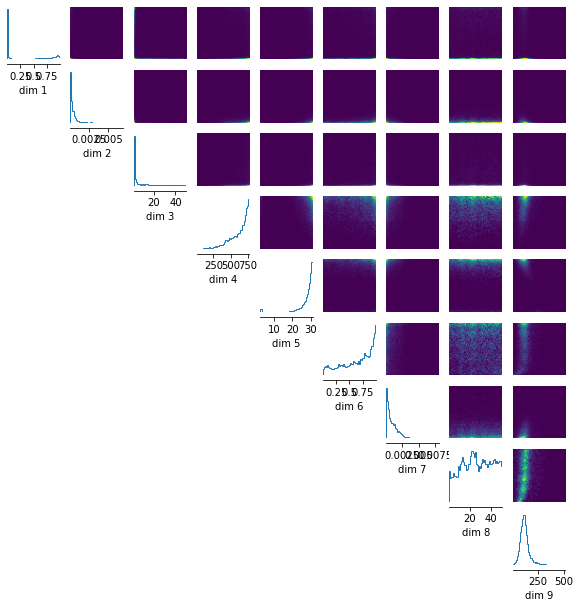

In [17]:
posterior_samples = posterior.sample((10000,),x = y[2]) # 50 mins for sampling

from sbi import analysis as analysis
_ = analysis.pairplot(
    posterior_samples, figsize=(10, 10)
)

In [ ]:
mdic = {"theta_new": posterior_samples.numpy(), "theta_old":theta.numpy(), "sims_old":x.numpy(),"observation":x_0.numpy()}
sio.savemat("BVCBM_SNPE_syn1_theta20k.mat", mdic)

In [22]:
proposal = posterior.set_default_x(x_0)

syn1_data_iter2 = sio.loadmat("BVCBM_SNPE_syn1_sims20k.mat")
theta1 = torch.from_numpy(syn1_data_iter2["theta_new"]).to(torch.float32)
x1 = torch.from_numpy(syn1_data_iter2["post_pred_sims1"]).to(torch.float32)
#x_0 = torch.from_numpy(syn1_data_iter2["observation"])

In [23]:
density_estimator = inference.append_simulations(theta1, x1, proposal=proposal).train()
posterior = inference.build_posterior(density_estimator)

Using SNPE-C with atomic loss


AssertionError: NaN/Inf present in prior eval.